In [ ]:
# Import required libraries and mount Google Drive

import os, time, math, io, requests
from concurrent.futures import ThreadPoolExecutor

# Data handling and numerical computation
import numpy as np
import pandas as pd
import scipy.stats as ss

# Machine learning and preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Google API libraries
!pip install --upgrade gspread google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client
import gspread
from google.oauth2.service_account import Credentials

# Progress bar utility
from tqdm import tqdm

# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# working directory project folder in Google Drive
pathname = '/content/drive/MyDrive/DataMiningTeam/'
os.chdir(pathname)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.1.4
    Uninstalling gspread-6.1.4:
      Successfully uninstalled gspread-6.1.4
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.160.0
    Uninstalling google-api-python-client-2.160.0:
      Successfully uninstalled google-api-python-client-2.160.0
Mounted at /content/drive


In [ ]:
# Load the raw Netflix dataset and perform data cleaning

filename = "netflix_database.xlsx"
dt = pd.read_excel(filename)

print("Initial dataset preview:")
display(dt.head())

# Fill missing values for director, cast, and country
dt[['director', 'cast', 'country']] = dt[['director', 'cast', 'country']].fillna("Unknown")

# Fill missing ratings with the most common rating (mode)
mode_rating = dt['rating'].mode()[0]
dt['rating'] = dt['rating'].fillna(mode_rating)

# Rename 'listed_in' to 'genre'
dt.rename(columns={'listed_in': 'genre'}, inplace=True)

# Drop rows with missing 'date_added' and extract day, month, year
dt = dt.dropna(subset=['date_added']).copy()
dt['day_added'] = dt['date_added'].dt.day.astype(int)
dt['month_added'] = dt['date_added'].dt.month.astype(int)
dt['year_added'] = dt['date_added'].dt.year.astype(int)

# Fill missing duration separately for TV Shows and Movies using mode
tv_mode = dt.loc[dt['type'] == 'TV Show', 'duration'].mode()[0]
mv_mode = dt.loc[dt['type'] == 'Movie', 'duration'].mode()[0]
dt.loc[dt['type'] == 'TV Show', 'duration'] = dt.loc[dt['type'] == 'TV Show', 'duration'].fillna(tv_mode)
dt.loc[dt['type'] == 'Movie', 'duration'] = dt.loc[dt['type'] == 'Movie', 'duration'].fillna(mv_mode)

# Extract numerical duration:
# For movies: extract minutes; for TV shows: extract number of seasons.
dt['duration_minutes'] = dt['duration'].apply(lambda x: float(x.split()[0]) if 'min' in str(x) else np.nan)
dt['duration_seasons'] = dt['duration'].apply(lambda x: float(x.split()[0]) if 'Season' in str(x) else np.nan)
dt.drop(columns=['duration'], inplace=True)

print("Missing values after cleaning:")
print(dt.isnull().sum())
print("\nDataset preview after cleaning:")
display(dt.head())


Initial dataset preview:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Missing values after cleaning:
show_id                0
type                   0
title                  0
director               0
cast                   0
country                0
date_added             0
release_year           0
rating                 0
genre                  0
description            0
day_added              0
month_added            0
year_added             0
duration_minutes    2666
duration_seasons    6131
dtype: int64

Dataset preview after cleaning:


,show_id,type,title,director,cast,country,date_added,release_year,rating,genre,description,day_added,month_added,year_added,duration_minutes,duration_seasons
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,Documentaries,"As her father nears the end of his life, filmm...",25,9,2021,90.0,NaN
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",24,9,2021,NaN,2.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,24,9,2021,NaN,1.0
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",24,9,2021,NaN,1.0
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,24,9,2021,NaN,2.0


In [ ]:
  #  Fetch missing IMDb ratings using the OMDb API with multithreading

  OMDB_API_KEY = "YOUR_OMDB_API_KEY"  # Replace with your actual OMDb API key
  OMDB_URL = "http://www.omdbapi.com/"

  def get_imdb_rating(title):
      params = {"t": title, "apikey": OMDB_API_KEY}
      try:
          response = requests.get(OMDB_URL, params=params, timeout=5)
          data = response.json()
          if response.status_code == 200 and data.get("Response") == "True":
              return data.get("imdbRating", "N/A")
      except Exception as e:
          print(f"Error fetching rating for {title}: {e}")
      return None

  # Ensure 'imdb_rating' exists
  if "imdb_rating" not in dt.columns:
      dt["imdb_rating"] = None

  titles_to_fetch = dt[(dt["imdb_rating"].isna()) | (dt["imdb_rating"] == "N/A")]["title"].tolist()

  with ThreadPoolExecutor(max_workers=20) as executor:
      results = list(tqdm(executor.map(get_imdb_rating, titles_to_fetch), total=len(titles_to_fetch)))

  for title, imdb in zip(titles_to_fetch, results):
      dt.loc[dt["title"] == title, "imdb_rating"] = imdb

  # Convert to numeric and fill any missing values with the median
  dt["imdb_rating"] = pd.to_numeric(dt["imdb_rating"], errors='coerce')
  median_rating = dt["imdb_rating"].median()
  dt["imdb_rating"].fillna(median_rating, inplace=True)

  file_path = "/content/drive/My Drive/DataMiningTeam/netflix_database_cleaned.xlsx"
  dt.to_excel(file_path, index=False)
  print(f"IMDb Ratings Fetching Complete! Data saved to: {file_path}")


100%|██████████| 8797/8797 [00:59<00:00, 147.17it/s]
<ipython-input-3-74884f858120>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dt["imdb_rating"].fillna(median_rating, inplace=True)


IMDb Ratings Fetching Complete! Data saved to: /content/drive/My Drive/DataMiningTeam/netflix_database_cleaned.xlsx


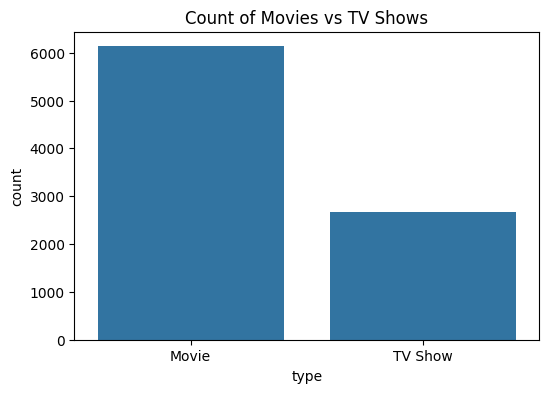

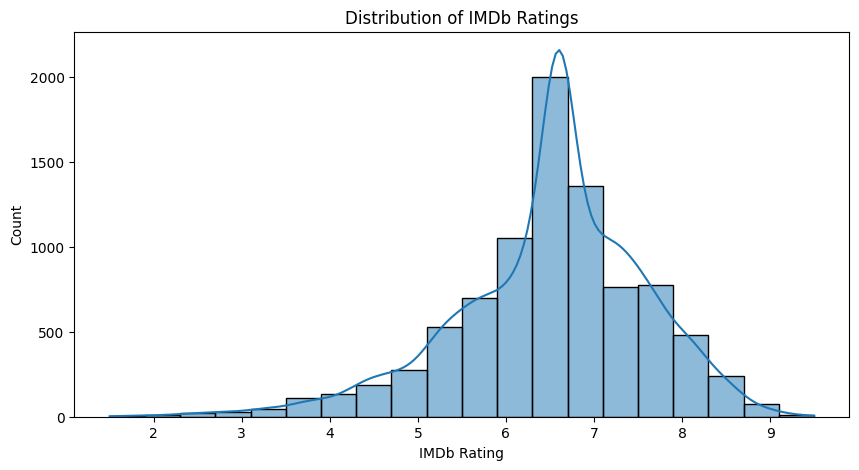

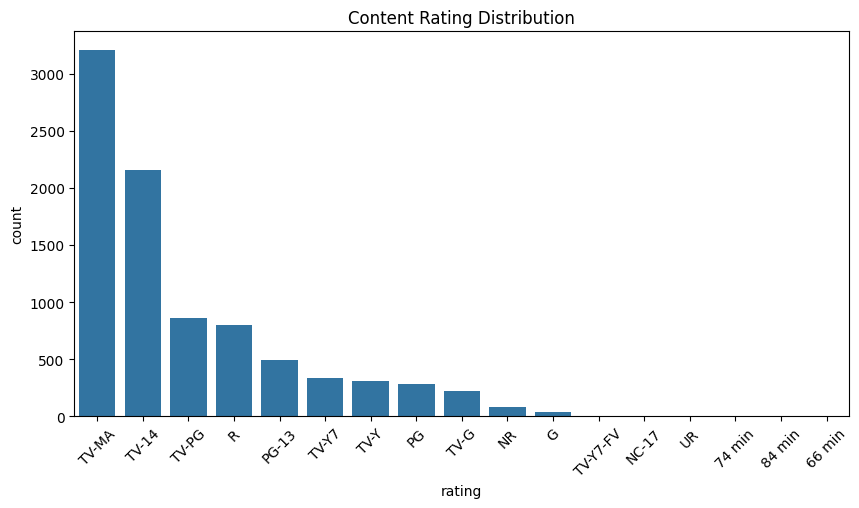

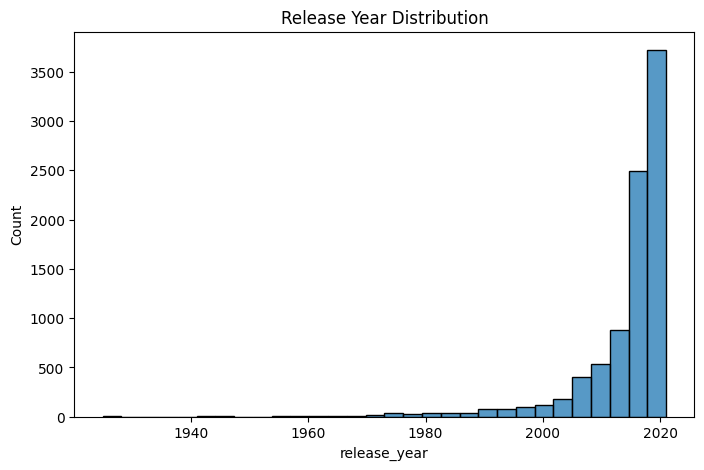

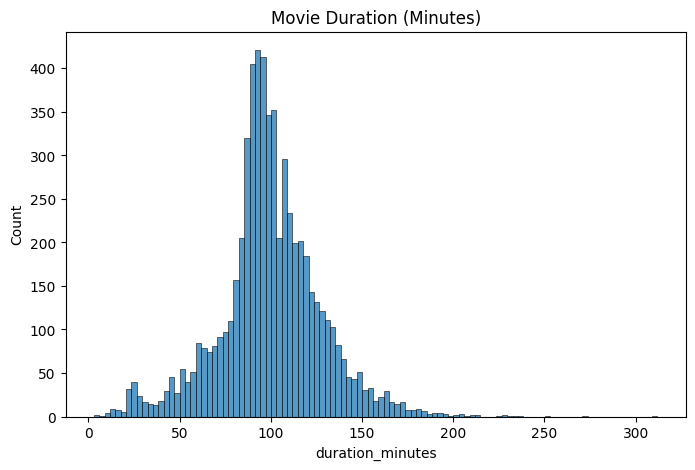

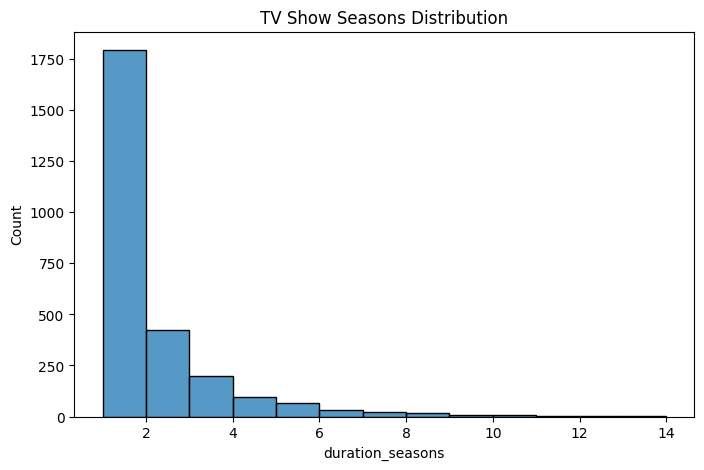

<ipython-input-4-2df7310a2b2e>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette="coolwarm")


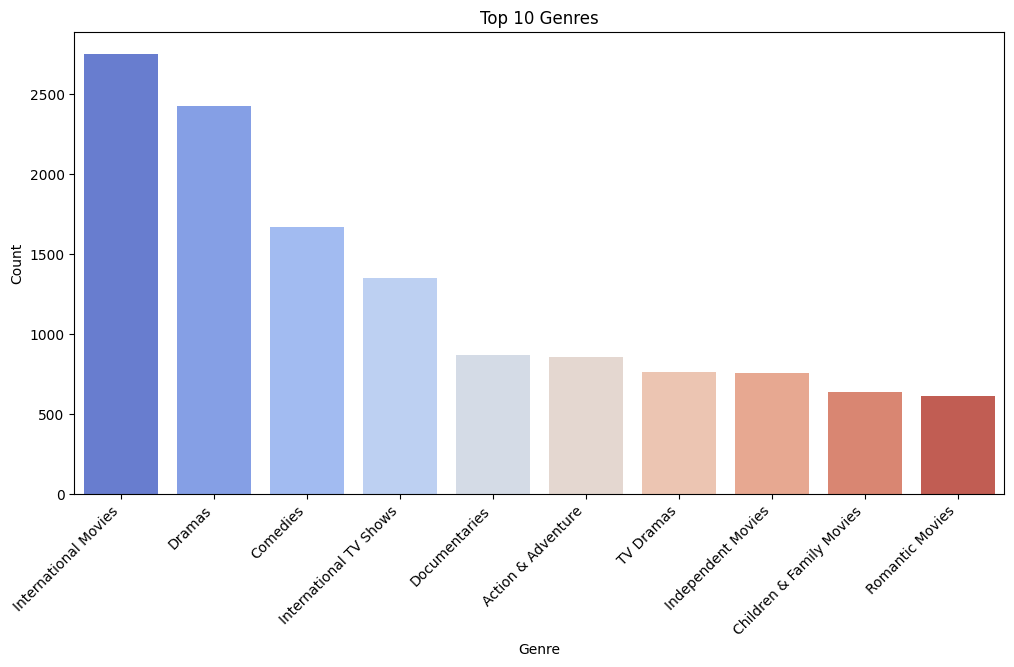

In [ ]:
# Cell 4: Visualize dataset characteristics

def plot_visualizations(dt):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='type', data=dt)
    plt.title('Count of Movies vs TV Shows')
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.histplot(dt["imdb_rating"].dropna(), bins=20, kde=True)
    plt.title("Distribution of IMDb Ratings")
    plt.xlabel("IMDb Rating")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.countplot(x='rating', data=dt, order=dt['rating'].value_counts().index)
    plt.title('Content Rating Distribution')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(x='release_year', data=dt, bins=30)
    plt.title('Release Year Distribution')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(x='duration_minutes', data=dt[dt['type'] == 'Movie'])
    plt.title('Movie Duration (Minutes)')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(x='duration_seasons', data=dt[dt['type'] == 'TV Show'], bins=range(1,15))
    plt.title('TV Show Seasons Distribution')
    plt.show()

    dt["genre_list"] = dt["genre"].fillna("").apply(lambda x: x.split(", "))
    all_genres = [genre for sublist in dt["genre_list"] for genre in sublist if genre]
    top_genres = pd.Series(all_genres).value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_genres.index, y=top_genres.values, palette="coolwarm")
    plt.xticks(rotation=45, ha="right")
    plt.title("Top 10 Genres")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.show()

plot_visualizations(dt)


In [ ]:
# engineered features

# Created a genre list from the 'genre' column
dt['genre_list'] = dt['genre'].fillna("").apply(lambda x: x.split(", "))

# One-hot encode genres
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(dt['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=dt.index)

# Scale release_year
scaler = MinMaxScaler()
dt['release_year_scaled'] = scaler.fit_transform(dt[['release_year']].fillna(dt['release_year'].min()))

# final feature-engineered DataFrame
dt_final = pd.concat([
    dt[['show_id', 'title', 'type', 'release_year_scaled', 'duration_minutes', 'duration_seasons']],
    genre_df
], axis=1).copy()

# Add IMDb rating
dt_final["imdb_rating"] = dt["imdb_rating"]

# Save engineered dataset
file_path = "/content/drive/My Drive/DataMiningTeam/netflix_feature_engineered.xlsx"
dt_final.to_excel(file_path, index=False)
print(f"Feature Engineered Dataset Saved: {file_path}")

print("Shape of dt_final:", dt_final.shape)
display(dt_final.head())


Feature Engineered Dataset Saved: /content/drive/My Drive/DataMiningTeam/netflix_feature_engineered.xlsx
Shape of dt_final: (8797, 49)


,show_id,title,type,release_year_scaled,duration_minutes,duration_seasons,Action & Adventure,Anime Features,Anime Series,British TV Shows,...,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers,imdb_rating
0,s1,Dick Johnson Is Dead,Movie,0.989583,90.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.4
1,s2,Blood & Water,TV Show,1.000000,NaN,2.0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,6.7
2,s3,Ganglands,TV Show,1.000000,NaN,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.2
3,s4,Jailbirds New Orleans,TV Show,1.000000,NaN,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.5
4,s5,Kota Factory,TV Show,1.000000,NaN,2.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,9.0


In [ ]:
# Construct the numerical feature matrix for similarity calculations
# and normalize IMDb ratings in one cell.

# First, update dt_final with normalized IMDb ratings.
dt_final["imdb_rating"] = pd.to_numeric(dt_final["imdb_rating"], errors='coerce')
median_imdb = dt_final["imdb_rating"].median()
dt_final["imdb_rating"] = dt_final["imdb_rating"].fillna(median_imdb)

scaler = MinMaxScaler()
dt_final["normalized_imdb"] = scaler.fit_transform(dt_final[["imdb_rating"]])

# Now, drop non-numeric columns and fill any remaining missing values.
feature_columns = dt_final.drop(columns=['show_id', 'title', 'type'], errors='ignore').fillna(0)
feature_matrix = feature_columns.to_numpy()

print("Feature Matrix Created!")
print("Shape:", feature_matrix.shape)
print("Sample rows:\n", feature_matrix[:1])


Feature Matrix Created!
Shape: (8797, 47)
Sample rows:
 [[ 0.98958333 90.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          7.4         0.7375    ]]


**[Link to Google Form for User Preference](https://docs.google.com/forms/d/e/1FAIpQLSc3yTl7V408XbWTpKTb97gebcTIytD5JZKOxCJzXTosKgE1SQ/viewform?usp=header)**

In [ ]:
#  Load user preferences via Google Sheets

# Load user preferences via Google Sheets and parse them into usable Python objects.

SERVICE_ACCOUNT_FILE = "/content/drive/My Drive/DataMiningTeam/service_account.json"

creds = Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE,
    scopes=["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
)
gc = gspread.authorize(creds)
print("Google Sheets Authentication Successful!")

SPREADSHEET_URL = "https://docs.google.com/spreadsheets/d/11COs6jCFzElSMi78x39_VZtGqhVOpi1pbNxZXMlR2qA/edit?usp=sharing"
spreadsheet = gc.open_by_url(SPREADSHEET_URL)
worksheet = spreadsheet.sheet1
data = worksheet.get_all_values()
latest_response = pd.DataFrame([data[-1]], columns=data[0])
print("User History Loaded!")

# Parse user responses
latest_response.columns = latest_response.columns.str.strip()

liked_movies = latest_response["Liked Movies/TV Shows"].values[0] if "Liked Movies/TV Shows" in latest_response else ""
disliked_movies = latest_response["Disliked Movies/TV Shows"].values[0] if "Disliked Movies/TV Shows" in latest_response else ""
preferred_genres = latest_response["Preferred Genres"].values[0] if "Preferred Genres" in latest_response else ""
imdb_min_rating = latest_response["IMDb Rating Preference"].values[0] if "IMDb Rating Preference" in latest_response else "No preference"
content_preference = latest_response["Do you prefer Movies or TV Shows?"].values[0] if "Do you prefer Movies or TV Shows?" in latest_response else "No preference"

liked_movies = liked_movies.split(", ") if liked_movies else []
disliked_movies = disliked_movies.split(", ") if disliked_movies else []
preferred_genres = preferred_genres.split(", ") if preferred_genres else []

if imdb_min_rating not in ["No preference", ""]:
    imdb_min_rating = float(imdb_min_rating.rstrip("+"))
else:
    imdb_min_rating = 0

print(f"Liked Movies: {liked_movies}")
print(f"Disliked Movies: {disliked_movies}")
print(f"Preferred Genres: {preferred_genres}")
print(f"IMDb Minimum Rating: {imdb_min_rating}")
print(f"Content Preference: {content_preference}")



Google Sheets Authentication Successful!
User History Loaded!
Liked Movies: ['Don', 'Dragon Quest Your Story', 'Prom Night', 'Miss Virginia']
Disliked Movies: ['Twogether', 'Brother']
Preferred Genres: ['International Movies', 'Romantic Movies', 'Comedies']
IMDb Minimum Rating: 7.2
Content Preference: Movies Only


In [ ]:

# Compute a weighted user profile based on liked movies and calculate cosine similarity.

# Find indices of movies the user likes.
liked_indices = dt_final[dt_final['title'].isin(liked_movies)].index.to_numpy()

# If no liked movies but preferred genres exist, use a fallback: select top 3 movies in those genres.
if len(liked_indices) == 0 and preferred_genres:
    genre_filtered = dt_final[dt_final[preferred_genres].sum(axis=1) > 0]
    liked_movies = genre_filtered['title'].head(3).tolist()
    liked_indices = dt_final[dt_final['title'].isin(liked_movies)].index.to_numpy()

# Compute user profile: weighted average of feature vectors for liked movies.
if len(liked_indices) > 0:
    weights = dt_final.iloc[liked_indices]['imdb_rating'] / dt_final.iloc[liked_indices]['imdb_rating'].sum()
    user_profile = np.average(feature_matrix[liked_indices], axis=0, weights=weights).reshape(1, -1)
else:
    # Fallback to using the average feature vector across all items if no liked movies.
    user_profile = np.mean(feature_matrix, axis=0).reshape(1, -1)

# Compute cosine similarity between the user profile and all items.
similarities = cosine_similarity(user_profile, feature_matrix)[0]
dt_final['similarity_score'] = similarities

# Compute adjusted similarity using a weighted sum (alpha for similarity, 1-alpha for normalized IMDb rating).
alpha = 0.7
dt_final["adjusted_similarity"] = alpha * dt_final["similarity_score"] + (1 - alpha) * dt_final["normalized_imdb"]

print("User Profile & Cosine Similarity Computed!")




User Profile & Cosine Similarity Computed!


In [ ]:
# Filter recommendations based on user preferences and display final content-based recommendations.

# Exclude items the user already liked or disliked.
recommended = dt_final[~dt_final['title'].isin(liked_movies)]
recommended = recommended[~recommended['title'].isin(disliked_movies)]
# Apply the IMDb rating filter.
recommended = recommended[recommended["imdb_rating"] >= imdb_min_rating]

# Fallback: If fewer than 10 recommendations are found, expand search using preferred genres.
if len(recommended) < 10:
    print("Less than 10 strong matches found. Expanding search with fallback recommendations...")
    if preferred_genres:
        fallback = dt_final[dt_final[preferred_genres].sum(axis=1) > 0]
        fallback = fallback.sort_values(by=["imdb_rating", "similarity_score"], ascending=[False, False])
        recommended = pd.concat([recommended, fallback]).drop_duplicates().head(10)
    else:
        recommended = recommended.head(10)

# If the user prefers a specific type, split recommendations accordingly.
recommended_movies = recommended[recommended["type"] == "Movie"]
recommended_shows = recommended[recommended["type"] == "TV Show"]

if content_preference == "Both":
    top_movies = recommended_movies.head(5)
    top_shows = recommended_shows.head(5)
    final_recommendations = pd.concat([top_movies, top_shows]).sort_values(by="adjusted_similarity", ascending=False)

elif content_preference == "Movies Only":
    final_recommendations = recommended_movies.head(10)

elif content_preference == "TV Shows Only":
    final_recommendations = recommended_shows.head(10)

else:  # "No preference" or any other input
    final_recommendations = recommended.head(10)

print("Top Recommendations:Based on Cosine Similarity")
display(final_recommendations[['title', 'type', 'imdb_rating', 'adjusted_similarity']])



Top Recommendations:Based on Cosine Similarity


,title,type,imdb_rating,adjusted_similarity
0,Dick Johnson Is Dead,Movie,7.4,0.920910
41,Jaws,Movie,8.1,0.947406
48,Training Day,Movie,7.8,0.936165
51,InuYasha the Movie 2: The Castle Beyond the Lo...,Movie,7.3,0.917307
52,InuYasha the Movie 3: Swords of an Honorable R...,Movie,7.6,0.928512
53,InuYasha the Movie 4: Fire on the Mystic Island,Movie,7.2,0.913403
54,InuYasha the Movie: Affections Touching Across...,Movie,7.2,0.913581
68,Schumacher,Movie,7.4,0.921120
84,Omo Ghetto: the Saga,Movie,7.6,0.928715
96,If I Leave Here Tomorrow: A Film About Lynyrd ...,Movie,7.8,0.935915


In [ ]:
# alternative recommendations using kNN.

# Initialize and fit the kNN model on the full feature matrix
knn = NearestNeighbors(n_neighbors=20, metric='cosine')
knn.fit(feature_matrix)

# Find the indices of the 20 nearest neighbors to the user profile
_, indices = knn.kneighbors(user_profile)
knn_recommendations = dt_final.iloc[indices[0]].copy()

# Compute cosine similarity for these kNN recommendations using their numeric features
# Note: Reconstruct the feature matrix for just these neighbors
neighbors_features = feature_columns.iloc[indices[0]].to_numpy()
knn_similarities = cosine_similarity(user_profile, neighbors_features)[0]
knn_recommendations['similarity_score'] = knn_similarities

# Compute adjusted similarity as a weighted sum of cosine similarity and normalized IMDb rating
alpha = 0.7  # weight for similarity; 30% weight for normalized IMDb rating
knn_recommendations["adjusted_similarity"] = alpha * knn_recommendations["similarity_score"] + (1 - alpha) * knn_recommendations["normalized_imdb"]

# Exclude items the user disliked
knn_recommendations = knn_recommendations[~knn_recommendations['title'].isin(disliked_movies)]

# Apply the minimum IMDb rating filter from user preference
knn_recommendations = knn_recommendations[knn_recommendations["imdb_rating"] >= imdb_min_rating]

# Filter recommendations based on content preference:
if content_preference == "Movies Only":
    knn_recommendations = knn_recommendations[knn_recommendations["type"] == "Movie"]
elif content_preference == "TV Shows Only":
    knn_recommendations = knn_recommendations[knn_recommendations["type"] == "TV Show"]


# Sort by adjusted similarity in descending order for final ranking
knn_recommendations = knn_recommendations.sort_values(by="adjusted_similarity", ascending=False)

print("Top kNN-Based Recommendations:")
display(knn_recommendations[['title', 'type', 'imdb_rating', 'adjusted_similarity']].head(10))


Top kNN-Based Recommendations:


,title,type,imdb_rating,adjusted_similarity
392,Django Unchained,Movie,8.5,0.962482
7077,Inglourious Basterds,Movie,8.4,0.958737
6427,Casino Royale,Movie,8.0,0.943736
6866,GoldenEye,Movie,7.2,0.913734


In [ ]:
# Association Rule Mining on Genre Data using Apriori

# Convert genre_df to boolean type.
genre_df = genre_df.astype(bool)

frequent_itemsets = apriori(genre_df, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

print("Association Rules based on genres (sample):")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Association Rules based on genres (sample):


,antecedents,consequents,support,confidence,lift
0,(Independent Movies),(Dramas),0.066841,0.777778,2.819164
1,(Dramas),(International Movies),0.168580,0.611042,1.953249
2,(TV Dramas),(International TV Shows),0.058429,0.674541,4.395507


In [ ]:
# Naïve Bayes classifier

# 1. Define 'like' using your synthetic rule
dt_final['like'] = (dt_final['imdb_rating'] >= 7.5).astype(int)

# 2. Combine user-labeled items
user_labeled_titles = set(liked_movies + disliked_movies)

# 3. Exclude those items from dt_final before building the train set
excluded_indices = dt_final[dt_final['title'].isin(user_labeled_titles)].index
train_dt = dt_final.drop(index=excluded_indices)

# 4. List columns we DO NOT want for model training
exclude_cols = [
    'show_id', 'title', 'type',            # not features
    'like', 'cluster', 'similarity_score', # or any added columns
    'adjusted_similarity', 'ensemble_score',
    'association_bonus', 'nb_score', 'cluster_score'
]

# 5. Prepare the training feature matrix
train_feature_cols = train_dt.drop(columns=exclude_cols, errors='ignore').fillna(0)
train_X = train_feature_cols.to_numpy()
train_y = train_dt['like'].values

# 6. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    train_X,
    train_y,
    test_size=0.2,
    random_state=42
)

clf = GaussianNB()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

# Evaluate the classifier
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)
rec = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Naïve Bayes classifier trained (excluding user-labeled items).")
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")


Naïve Bayes classifier trained (excluding user-labeled items).
Accuracy: 0.84, Precision: 0.54, Recall: 0.59, F1 Score: 0.57


In [ ]:
# Re-applying  the model to the FULL dt_final so we can get nb_score for all items
full_feature_cols = dt_final.drop(columns=exclude_cols, errors='ignore').fillna(0)
full_X = full_feature_cols.to_numpy()

nb_proba_all = clf.predict_proba(full_X)[:, 1]
dt_final['nb_score'] = nb_proba_all

print("Example nb_score:")
display(dt_final[['title', 'nb_score']].head(10))


Example nb_score:


,title,nb_score
0,Dick Johnson Is Dead,5.115224e-03
1,Blood & Water,1.000000e+00
2,Ganglands,1.000000e+00
3,Jailbirds New Orleans,1.622049e-05
4,Kota Factory,9.999916e-01
5,Midnight Mass,1.000000e+00
6,My Little Pony: A New Generation,5.565218e-14
7,Sankofa,3.775977e-07
8,The Great British Baking Show,1.000000e+00
9,The Starling,1.969779e-12


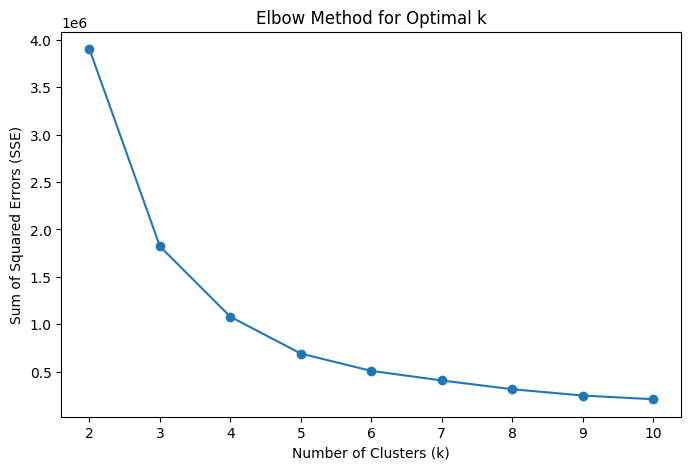

In [ ]:
# Elbow

sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(feature_matrix)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sse, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()


In [ ]:
# Apply K-Means clustering to group items



print("Trying different k values for K-Means:")
for k in range(3, 10):
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    clusters_temp = kmeans_temp.fit_predict(feature_matrix)
    sil_score = silhouette_score(feature_matrix, clusters_temp)
    print(f"k={k}: Cluster Distribution: {np.bincount(clusters_temp)} | Silhouette Score: {sil_score:.3f}")

# Set optimal k
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(feature_matrix)
dt_final['cluster'] = clusters

print("K-Means clustering complete. Cluster distribution:")
print(dt_final['cluster'].value_counts())


Trying different k values for K-Means:
k=3: Cluster Distribution: [2915 4155 1727] | Silhouette Score: 0.665
k=4: Cluster Distribution: [2807 3650 1326 1014] | Silhouette Score: 0.659
k=5: Cluster Distribution: [2796 1787  571  810 2833] | Silhouette Score: 0.649
k=6: Cluster Distribution: [2779 2045  339  667 1778 1189] | Silhouette Score: 0.625
k=7: Cluster Distribution: [2766 2253  656  550 1082 1327  163] | Silhouette Score: 0.613
k=8: Cluster Distribution: [2689 1671  710  632  201 1137  254 1503] | Silhouette Score: 0.610
k=9: Cluster Distribution: [2689 1573  722  632  281 1103  254 1503   40] | Silhouette Score: 0.610
K-Means clustering complete. Cluster distribution:
cluster
1    3650
0    2807
2    1326
3    1014
Name: count, dtype: int64



Silhouette Bar Chart for K-Means:


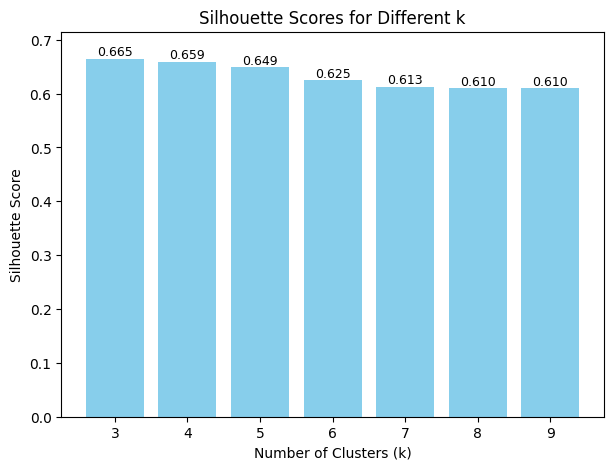

In [ ]:
#  Silhouette Bar Chart

# We'll reuse the range(3, 10) and store silhouette scores in a list for plotting
k_values = list(range(3, 10))
silhouette_scores = []

print("\nSilhouette Bar Chart for K-Means:")
for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    clusters_temp = kmeans_temp.fit_predict(feature_matrix)
    sil_score = silhouette_score(feature_matrix, clusters_temp)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(7, 5))
plt.bar(k_values, silhouette_scores, color='skyblue')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
for i, score in enumerate(silhouette_scores):
    plt.text(k_values[i], score, f"{score:.3f}", ha='center', va='bottom', fontsize=9)
plt.ylim(0, max(silhouette_scores) + 0.05)
plt.show()


In [ ]:
#  Cluster Profiling

# Suppose you want to see the average IMDb rating, release_year_scaled,
# and the top 5 genres in each cluster.

genre_cols = genre_df.columns  # from your one-hot-encoded df
unique_clusters = sorted(dt_final['cluster'].unique())

print("\n=== Cluster Profiling ===")
for c in unique_clusters:
    cluster_data = dt_final[dt_final['cluster'] == c]
    print(f"\n--- Cluster {c} ---")
    print(f"Number of items: {len(cluster_data)}")
    print(f"Average IMDb rating: {cluster_data['imdb_rating'].mean():.2f}")
    print(f"Average release_year_scaled: {cluster_data['release_year_scaled'].mean():.2f}")

    # Summation over genre columns to see which genres are most common
    cluster_genre_sum = cluster_data[genre_cols].sum().sort_values(ascending=False).head(5)
    print("Top 5 genres:")
    display(cluster_genre_sum)



=== Cluster Profiling ===

--- Cluster 0 ---
Number of items: 2807
Average IMDb rating: 6.92
Average release_year_scaled: 0.95
Top 5 genres:


,0
International TV Shows,1350
TV Dramas,762
TV Comedies,574
Crime TV Shows,469
Kids' TV,449



--- Cluster 1 ---
Number of items: 3650
Average IMDb rating: 6.16
Average release_year_scaled: 0.92
Top 5 genres:


,0
International Movies,1590
Dramas,1432
Comedies,1170
Independent Movies,572
Action & Adventure,519



--- Cluster 2 ---
Number of items: 1326
Average IMDb rating: 6.66
Average release_year_scaled: 0.89
Top 5 genres:


,0
International Movies,934
Dramas,885
Comedies,364
Action & Adventure,313
Romantic Movies,179



--- Cluster 3 ---
Number of items: 1014
Average IMDb rating: 6.42
Average release_year_scaled: 0.94
Top 5 genres:


,0
Documentaries,305
Stand-Up Comedy,298
International Movies,208
Children & Family Movies,206
Comedies,120


In [ ]:
# Compute an ensemble recommendation score combining multiple methods

# Ensure 'normalized_imdb' exists; recompute if missing
if "normalized_imdb" not in dt_final.columns:
    print(" 'normalized_imdb' column missing. Recomputing...")
    dt_final["imdb_rating"] = pd.to_numeric(dt_final["imdb_rating"], errors='coerce')
    median_imdb = dt_final["imdb_rating"].median()
    dt_final["imdb_rating"] = dt_final["imdb_rating"].fillna(median_imdb)
    scaler = MinMaxScaler()
    dt_final["normalized_imdb"] = scaler.fit_transform(dt_final[["imdb_rating"]])

# Ensure 'adjusted_similarity' exists; recompute if missing
if "adjusted_similarity" not in dt_final.columns:
    print(" 'adjusted_similarity' missing. Recomputing...")
    similarities = cosine_similarity(user_profile, feature_matrix)[0]
    dt_final['similarity_score'] = similarities
    alpha = 0.7  # weight for similarity
    dt_final["adjusted_similarity"] = alpha * dt_final["similarity_score"] + (1 - alpha) * dt_final["normalized_imdb"]
    dt_final["adjusted_similarity"] = dt_final["adjusted_similarity"].fillna(0)


# Get Naïve Bayes classifier probability for the positive (like) class
nb_proba = clf.predict_proba(feature_matrix)[:, 1]
dt_final['nb_score'] = nb_proba

# Compute fraction of liked movies in each cluster as a measure of cluster preference
liked_clusters = dt_final.loc[dt_final['title'].isin(liked_movies), 'cluster']
if len(liked_clusters) > 0:
    cluster_pref = liked_clusters.value_counts(normalize=True).to_dict()
else:
    cluster_pref = {}
dt_final['cluster_score'] = dt_final['cluster'].apply(lambda x: cluster_pref.get(x, 0))

# Adjust ensemble score weights: Here, we use 0.4 for adjusted similarity, 0.4 for NB score, and 0.2 for cluster score.
# (tweak these weights to get a better balance of quality vs. diversity.)
total = 0.4 + 0.4 + 0.5

w_adj = 0.5/total
w_nb_score = 0.4/total
w_cluster_score = 0.4/total



dt_final['ensemble_score'] = (w_adj * dt_final['adjusted_similarity'] +
                              w_nb_score * dt_final['nb_score'] +
                              w_cluster_score * dt_final['cluster_score'])

#  association rule
associated_titles = []

dt_final['association_bonus'] = dt_final['title'].apply(lambda t: 0.05 if t in associated_titles else 0)
dt_final['ensemble_score'] += dt_final['association_bonus']

# Filter out liked and disliked items from ensemble recommendations
ensemble_recs = dt_final[~dt_final['title'].isin(liked_movies)]
ensemble_recs = ensemble_recs[~ensemble_recs['title'].isin(disliked_movies)]
ensemble_recs = ensemble_recs.sort_values(by='ensemble_score', ascending=False)

print(" Final Recommendations:")
display(ensemble_recs[['title', 'type', 'imdb_rating', 'ensemble_score']].head(10))


 Final Recommendations:


,title,type,imdb_rating,ensemble_score
4217,Monty Python and the Holy Grail,Movie,8.2,0.904121
4552,Monty Python's Life of Brian,Movie,8.0,0.901261
6431,Cat on a Hot Tin Roof,Movie,7.9,0.899925
333,Ferris Bueller's Day Off,Movie,7.8,0.898450
8745,Willy Wonka & the Chocolate Factory,Movie,7.8,0.898439
6358,Bonnie and Clyde,Movie,7.7,0.897060
7839,Rebel Without a Cause,Movie,7.6,0.895620
6701,Enter the Dragon,Movie,7.6,0.895600
2369,Dark Waters,Movie,7.6,0.895591
6784,Forbidden Planet,Movie,7.5,0.894122
